In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo
import numpy as np
from scipy.stats import norm

In [ ]:
# fetch dataset 
air_quality = fetch_ucirepo(id=360)
# data (as pandas dataframes) 
X = air_quality.data.features 
y = air_quality.data.targets
df = pd.concat([X, y], axis=1)
df = df.drop('Date', axis=1)
df = df.drop('Time', axis=1)
# print(df.head(50))
df = df.apply(pd.to_numeric, errors='coerce')
neg = (df == -200).any(axis=1).sum()
print(f" % precent of rows with at least 1 negative value: {neg / len(df) * 100}")
# since 91% of rows are like this, we can't delete the rows, so we have to impute
# avg of forward and backward fill instead of using just mean value of colum
df = df.replace(-200, pd.NA)
df = (df.ffill() + df.bfill()) / 2
print(df.head(20))

         Date      Time  CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  \
0   3/10/2004  18:00:00     2.6         1360       150      11.9   
1   3/10/2004  19:00:00     2.0         1292       112       9.4   
2   3/10/2004  20:00:00     2.2         1402        88       9.0   
3   3/10/2004  21:00:00     2.2         1376        80       9.2   
4   3/10/2004  22:00:00     1.6         1272        51       6.5   
5   3/10/2004  23:00:00     1.2         1197        38       4.7   
6   3/11/2004   0:00:00     1.2         1185        31       3.6   
7   3/11/2004   1:00:00     1.0         1136        31       3.3   
8   3/11/2004   2:00:00     0.9         1094        24       2.3   
9   3/11/2004   3:00:00     0.6         1010        19       1.7   
10  3/11/2004   4:00:00  -200.0         1011        14       1.3   
11  3/11/2004   5:00:00     0.7         1066         8       1.1   
12  3/11/2004   6:00:00     0.7         1052        16       1.6   
13  3/11/2004   7:00:00     1.1         1144    

/var/folders/h3/srj0ks150b74jtpr2zl0w3d40000gn/T/ipykernel_55438/3140530254.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = (df.ffill() + df.bfill()) / 2


                 CO(GT)  PT08.S1(CO)         T        RH        AH  \
CO(GT)         1.000000     0.795434  0.021706  0.052626  0.053092   
PT08.S1(CO)    0.795434     1.000000  0.031231  0.115001  0.111822   
T              0.021706     0.031231  1.000000 -0.573925  0.659798   
RH             0.052626     0.115001 -0.573925  1.000000  0.169807   
AH             0.053092     0.111822  0.659798  0.169807  1.000000   
PT08.S2(NMHC)  0.811212     0.891949  0.231117 -0.090553  0.170338   
PT08.S3(NOx)  -0.649302    -0.776695 -0.126278 -0.062220 -0.212254   
PT08.S4(NO2)   0.555702     0.666380  0.561967 -0.027533  0.630018   
PT08.S5(O3)    0.777544     0.901653 -0.046929  0.125729  0.043921   

               PT08.S2(NMHC)  PT08.S3(NOx)  PT08.S4(NO2)  PT08.S5(O3)  
CO(GT)              0.811212     -0.649302      0.555702     0.777544  
PT08.S1(CO)         0.891949     -0.776695      0.666380     0.901653  
T                   0.231117     -0.126278      0.561967    -0.046929  
RH         

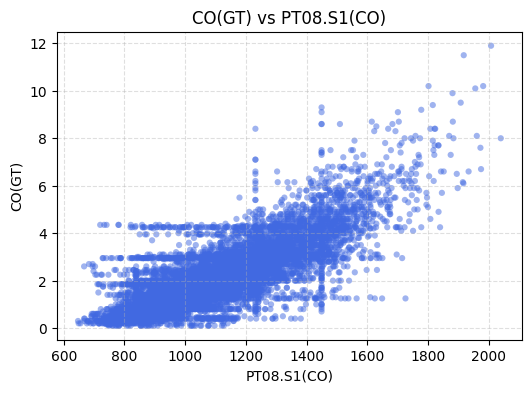

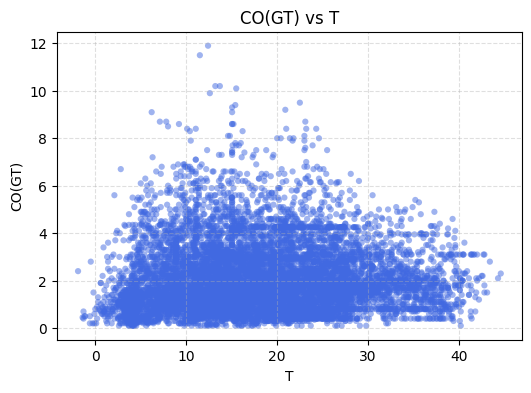

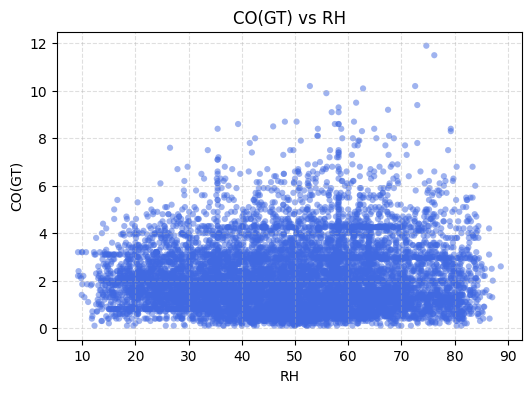

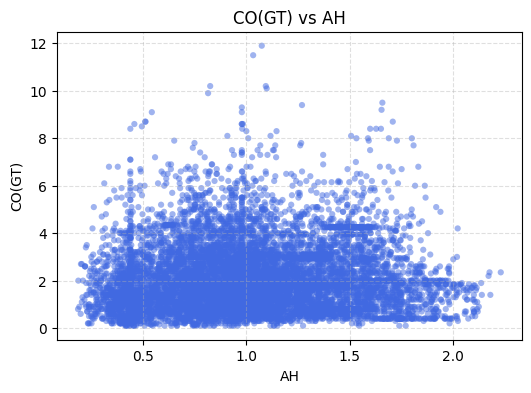

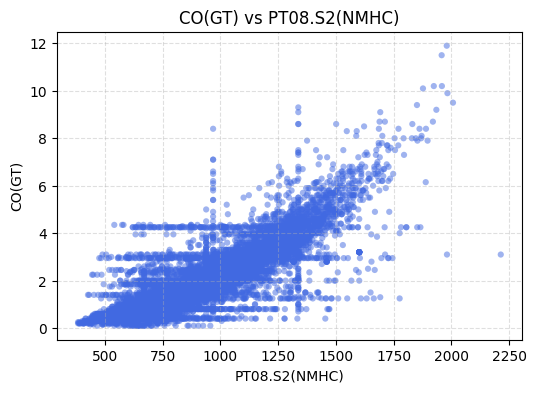

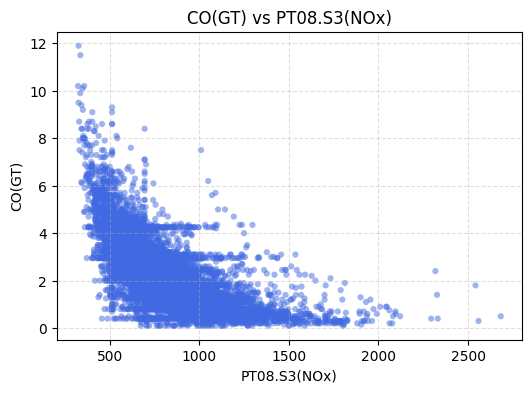

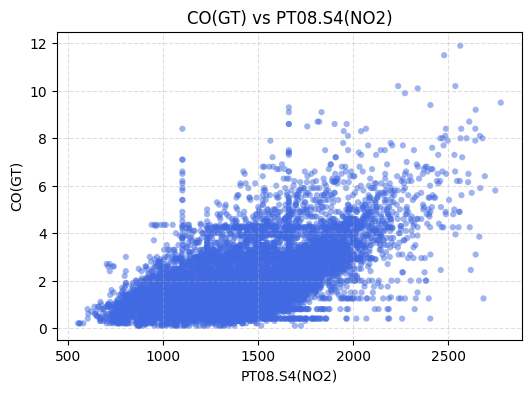

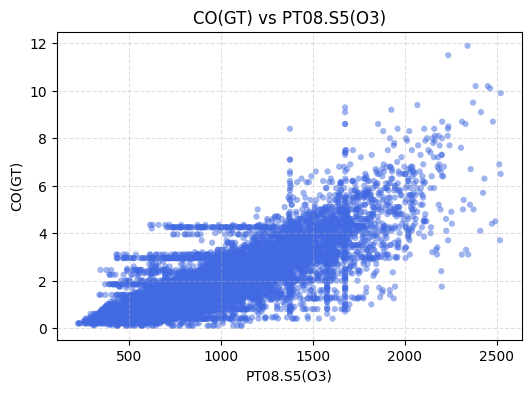

In [7]:
# non target variables vs CO(GT) plots
y = 'CO(GT)'
variables = [
    'PT08.S1(CO)', 'T', 'RH', 'AH',
    'PT08.S2(NMHC)', 'PT08.S3(NOx)',
    'PT08.S4(NO2)', 'PT08.S5(O3)'
]
corr_vars = [y] + variables 
corr_matrix = df[corr_vars].corr()
print(corr_matrix)
for x in variables:
    plt.figure(figsize=(6, 4))
    plt.scatter(df[x], df[y], s=20, alpha=0.5, color='royalblue', edgecolors='none')
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(f'{y} vs {x}')
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.show()


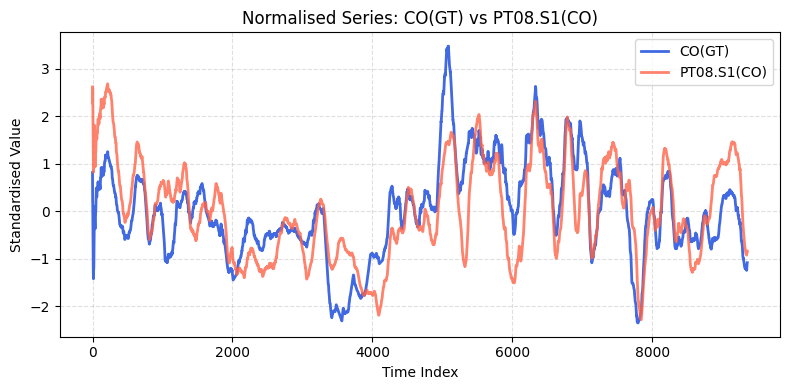

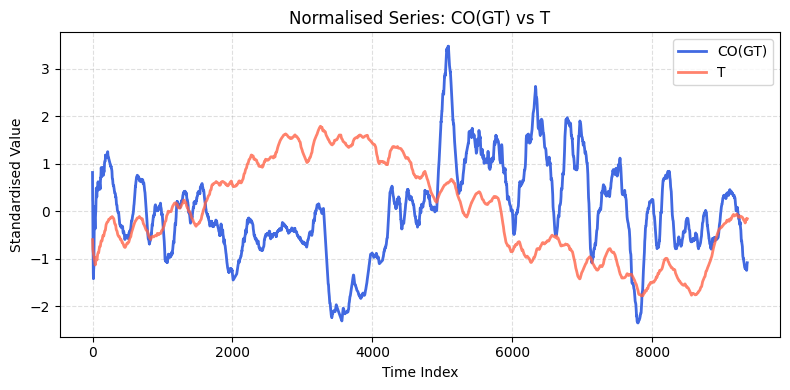

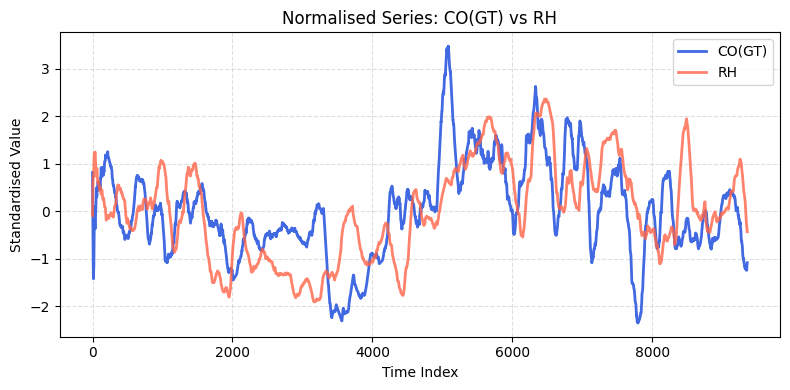

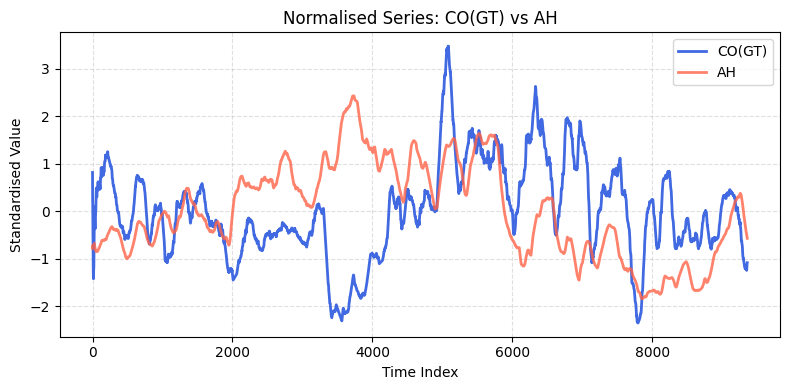

Lag correlations with current CO(GT):
Lag-1: 0.860
Lag-2: 0.660
Lag-3: 0.497


In [ ]:
# time series plots: normalised moving average
variables = ['PT08.S1(CO)', 'T', 'RH', 'AH']
target = 'CO(GT)'

for col in variables:
    plt.figure(figsize=(8,4))

    target_smooth = df[target].rolling(window=24*7, min_periods=1).mean()
    target_norm = (target_smooth - target_smooth.mean()) / target_smooth.std()
    
    feature_smooth = df[col].rolling(window=24*7, min_periods=1).mean()
    feature_norm = (feature_smooth - feature_smooth.mean()) / feature_smooth.std()
    
    plt.plot(df.index, target_norm, label=target, color='royalblue', linewidth=2)
    plt.plot(df.index, feature_norm, label=col, color='tomato', linewidth=2, alpha=0.8)
    plt.title(f'Normalised Series: {target} vs {col}')
    plt.xlabel('Time Index')
    plt.ylabel('Standardised Value')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()
    
lags = [1, 2, 3]
print("Lag correlations with current CO(GT):")
for lag in lags:
    correlation = df['CO(GT)'].corr(df['CO(GT)'].shift(lag))
    print(f"Lag {lag}: {correlation:.3f}")


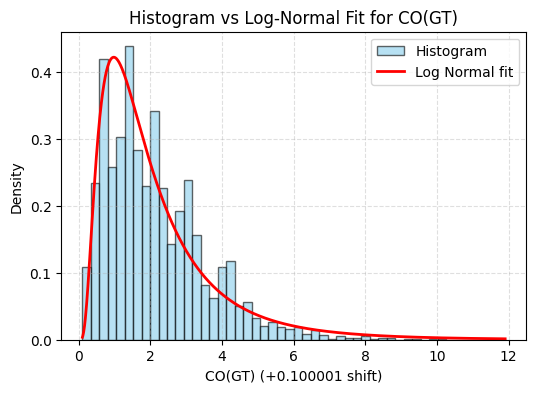

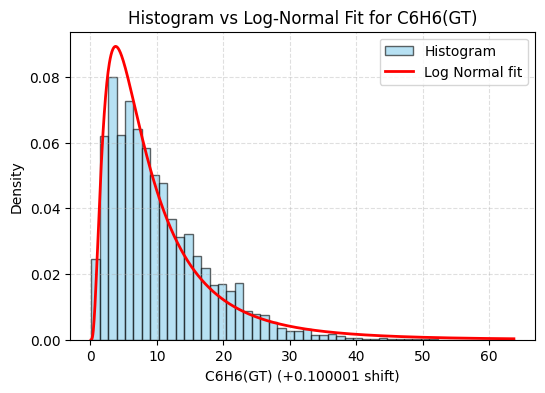

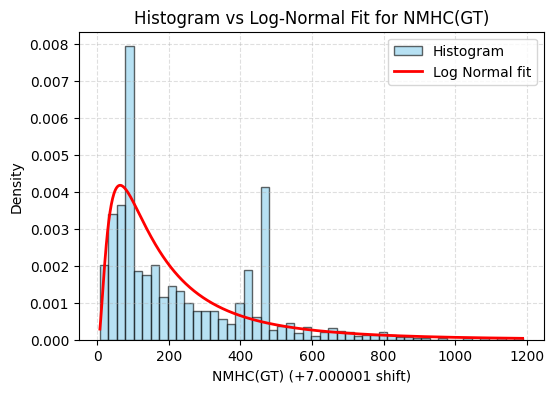

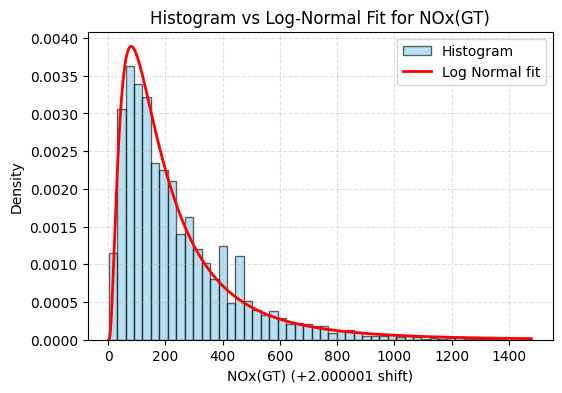

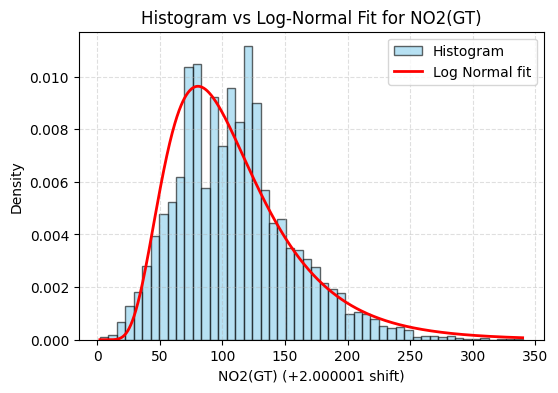

In [7]:
# distribution plots

variables = [
    'CO(GT)', 'C6H6(GT)', 'NMHC(GT)', 'NOx(GT)', 'NO2(GT)',
    ]

for y in variables:

    data = pd.to_numeric(df[y], errors='coerce').dropna()
    # +ve vals only
    shift = abs(data.min()) + 1e-6
    if (data <= 0).any():
        data = data + shift
    
    # If Y = log(X) and Y ~ Normal ==> X ~ log normal
    log_data = np.log(data)
    mu, sigma = norm.fit(log_data)
    x = np.linspace(data.min(), data.max(), 1000)
    pdf = (1 / (x * sigma * np.sqrt(2 * np.pi))) * np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2))
    
    plt.figure(figsize=(6, 4))
    plt.hist(data, bins=50, density=True, alpha=0.6, color='skyblue', edgecolor='black', label='Histogram')
    plt.plot(x, pdf, 'r', lw=2, label='Log Normal fit')
    xlabel = f"{y} (+{shift:.6f} shift)" if shift > 0 else y
    plt.xlabel(xlabel)
    plt.ylabel('Density')
    plt.title(f'Histogram vs Log-Normal Fit for {y}')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.show()